# The Inner Workings: Probability/Likelihood Analysis

## Introduction
How do we solve an NLU task using a generative model without finetuning?

### Prediction Equation

Given a set of potential labels $L = \{l_1, l_2, \dots, l_n\}$ and their corresponding probabilities $P = \{p_1, p_2, \dots, p_n\}$, the predicted label $\hat{y}$ is the label with the highest probability:

$$
\hat{y} = \underset{l_i \in L}{\arg\max} \, p_i
$$

Where:
- $\hat{y}$ is the predicted label.
- $l_i$ is a potential label.
- $p_i$ is the probability of label $l_i$.
- $\arg\max$ selects the label $l_i$ that maximizes $p_i$.


If you are familiar with probability, you are selecting the label sequence with the highest likelihood given the task and input.

## Install Dependencies

In [1]:
!pip install transformers
!pip install torch

### Step 2: Import Libraries

Import the required libraries for the notebook.

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

### Step 3: Load the Pre-trained Generative Model

Load a pre-trained generative model (e.g., GPT-2) and its tokenizer.

In [3]:
# Load the GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Step 4: Define the Task, Prompt, and Input

Define the task, prompt, and input(s) for the model. For example, let's say the task is to classify a sentence as "Positive" or "Negative".

In [4]:
# Define the task, prompt, and input
task = "Classify the following sentence as 'Positive' or 'Negative':"
input_sentence = "I had a wonderful day at the park!"
prompt = f"{task} {input_sentence}"

print("Prompt:", prompt)

Prompt: Classify the following sentence as 'Positive' or 'Negative': I had a wonderful day at the park!


### Step 5: Tokenize the Input and Generate Output

Tokenize the input and generate output using the generative model.

In [5]:
# Tokenize the input
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate output
with torch.no_grad():
    output = model.generate(input_ids, max_length=50, num_return_sequences=1, output_scores=True, return_dict_in_generate=True)

# Decode the generated output
generated_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Text: Classify the following sentence as 'Positive' or 'Negative': I had a wonderful day at the park!

I had a wonderful day at the park!

I had a wonderful day at the park!

I had


### Step 6: Extract Probabilities for Potential Labels

Extract the probabilities for the potential labels (e.g., "Positive" and "Negative") from the model's output.

In [15]:
# Define potential labels
potential_labels = ["Positive", "Negative"]

# Get the logits for the next token after the input
logits = output.scores[0][0]

# Convert logits to probabilities
probs = torch.softmax(logits, dim=-1)

# Get the probabilities for the potential labels
label_probs = {}
for label in potential_labels:
    label_id = tokenizer.encode(label, return_tensors="pt")[0][0]
    print(f'Label: {label}, Label ID: {label_id}')
    label_probs[label] = probs[label_id].item()

print("Label Probabilities:", label_probs)

Label: Positive, Label ID: 21604
Label: Negative, Label ID: 32863
Label Probabilities: {'Positive': 5.594800313701853e-05, 'Negative': 2.919611006291234e-06}


### Step 7: Evaluate the Model

Evaluate the model by comparing the probabilities of the potential labels. The label with the highest probability is the predicted label.



In [9]:
# Get the predicted label
predicted_label = max(label_probs, key=label_probs.get)
print("Predicted Label:", predicted_label)

# Compare with the ground truth (if available)
ground_truth = "Positive"
print("Ground Truth:", ground_truth)
print("Correct Prediction:", predicted_label == ground_truth)

Predicted Label: Positive
Ground Truth: Positive
Correct Prediction: True


### Step 8: Visualize the Results

Visualize the probabilities of the potential labels using a bar plot.

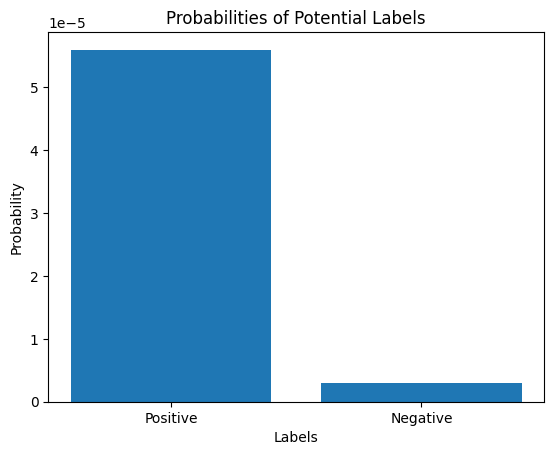

In [11]:
import matplotlib.pyplot as plt

# Plot the probabilities
plt.bar(label_probs.keys(), label_probs.values())
plt.xlabel("Labels")
plt.ylabel("Probability")
plt.title("Probabilities of Potential Labels")
plt.show()

### Step 9: Experiment with Different Inputs

In [12]:
# Example: Try a different input sentence
input_sentence = "I feel terrible about what happened."
prompt = f"{task} {input_sentence}"

# Repeat Steps 5-7 to generate and evaluate the output

## Questions:
1. What if my labels/targets are more than one token?

In [17]:
# Define multi-token labels with EOS
potential_labels = ["Very Positive", "Not Negative", "Neutral"]

# Add EOS token to each label
eos_token = tokenizer.eos_token
potential_labels = [label + eos_token for label in potential_labels]

# Function to compute the joint probability of a multi-token label with EOS
def compute_joint_probability_with_eos(label, model, tokenizer, input_ids):
    # Tokenize the label
    label_ids = tokenizer.encode(label, return_tensors="pt")[0]
    
    # Initialize joint probability
    joint_prob = 1.0
    
    # Iterate through the tokens of the label
    for i, token_id in enumerate(label_ids):
        # Get the logits for the next token
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[0, -1, :]  # Logits for the next token
        
        # Compute the probability of the current token in the label
        probs = torch.softmax(logits, dim=-1)
        token_prob = probs[token_id].item()
        
        # Update the joint probability
        joint_prob *= token_prob
        
        
        # Append the current token to the input_ids for the next prediction
        input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=1)
    
    return joint_prob

# Compute joint probabilities for all potential labels
label_probs = {}
for label in potential_labels:
    joint_prob = compute_joint_probability_with_eos(label, model, tokenizer, input_ids)
    label_probs[label.replace(eos_token, "")] = joint_prob  # Remove EOS for readability

print("Joint Probabilities for Multi-Token Labels (with EOS):", label_probs)

# Get the predicted label
predicted_label = max(label_probs, key=label_probs.get)
print("Predicted Label:", predicted_label)

Joint Probabilities for Multi-Token Labels (with EOS): {'Very Positive': 3.577389654561771e-11, 'Not Negative': 2.594454815851032e-11, 'Neutral': 8.965088374115351e-10}
Predicted Label: Neutral


2. What if we have a really long target sequence and the probability becomes near 0? \[HINT: The name of this file.\]
3. Are there any shortcuts you think we can take?
4. What metrics do you think we can use for evaluating these predictions? What are the pros and cons?
5. How would generative tasks be evaluated?